In [1]:
import random

class player:
    def __init__(self, swap):
        self.swap = swap
        
    def chooseDoor(self):
        return random.choice(host.drange)



class door:    
    def __init__(self, number):
        self.number = number
        self.prize = False      
    
    def __str__(self):
        return 'door(%d, %s)' % (self.number, self.prize)
        
    def __repr__(self):
        return(self.__str__())



class host:
    drange = range(3)
    
    def play(self, player):
        # make the doors
        doors = [door(n) for n in host.drange]
        # pick a door for the prize
        doors[random.choice(host.drange)].prize = True
        # player picks a door
        choice = doors[player.chooseDoor()]
        # copy doors
        remain = doors[:]
        # remove players choice
        remain.remove(choice)
        # shuffle two not choosen doors
        random.shuffle(remain)
        # pick door to show
        show, last = remain
        if show.prize:
            # if show has prize, pick other door to show
            show, last = last, show
        # did player swap?
        finalChoice = last if player.swap else choice
        return(finalChoice.prize)
        
    def playLots(self, player, lots):
        cnt = 0
        for j in range(lots):
            if self.play(player):
                cnt += 1
        return (float(cnt)/lots)
    
h = host()
pns = player(False)
ps = player(True)


In [2]:
h.playLots(pns, 1000*1000)


0.333195

In [3]:
h.playLots(ps, 1000*1000)

0.66609

# Faster!
- There are versions of Python that try to 'go faster'
- as an unscientific benchmark, i used a 'monte carlo' 'monty hall' program 
- in normal(Cpython) python, running the game a million times takes about 12 secs
- Java or C code would do it in under a second

# [cython](http://docs.cython.org/src/tutorial/cython_tutorial.html)
- writes a 'C' version of your Python code, which in theory might run faster
- C program is remarkably complex and long. 
- optional declarations can be added for various datatypes, like int and float, which allows optimizations to take place
- not much speedup on monte
- a more numeric program would be probably see bigger gains
- to try 'monte' put this in a 'setup.py' file:
- runs monte hall in about 9 seconds

```
from distutils.core import setup
from Cython.Build import cythonize

setup(
  name = 'monte',
  ext_modules = cythonize("monte.pyx"),
)
```

  - now run 

```
python setup.py build_ext --inplace
```

  - generates monte.c - very complex code!
  - compiles monte.c to make monte.so(shared library)
  - the monte*.so library file can be imported in python(which proves you can load C code into python)

```
# loads the shared library

from monte import *

meg = 1000*1000

# names are in monte module

monte.h.playLots(monte.ps, meg)

```


# [PyPY](http://pypy.org)
- uses a JIT(Just in Time Compiler), like Java has
- in theory can do better than static code compiler
- sees what program is actually doing and optimizes accordingly
- uses a simple garbage collector instead of reference counting
- easy to use - just load code as usual, no preprocessing like Cython
- runs monte hall in ~1 seccond
- downsides
    - implements python 2.7
    - lacks symbol completion
    - Numpy support is not complete

# Python with GPUs
- alot of work going into integrating python with GPUs - best of both worlds
- [Accelerate](https://store.continuum.io/cshop/accelerate/)
  - can move many numpy functions into [GPU](http://nbviewer.ipython.org/github/ContinuumIO/numbapro-examples/blob/master/webinars/2014_06_17/intro_to_gpu_python.ipynb)
- [theano](http://deeplearning.net/software/theano/)

# Numba
- JIT compilier that works in normal python
- just add @jit decoration

In [4]:
# pretty slow 

%timeit

from numba import jit
from numpy import arange

def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(33333333).reshape(11111111,3)
print(sum2d(a))

5.55555527778e+14


In [5]:
# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.

@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(33333333).reshape(11111111,3)
print(sum2d(a))

555555527777778.0


7.995366559500051


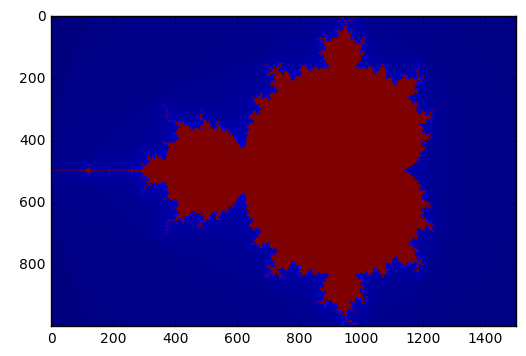

In [6]:

from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import jit
%matplotlib inline

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
imshow(image)
#jet()
#ion()
show()

0.26472028774461975


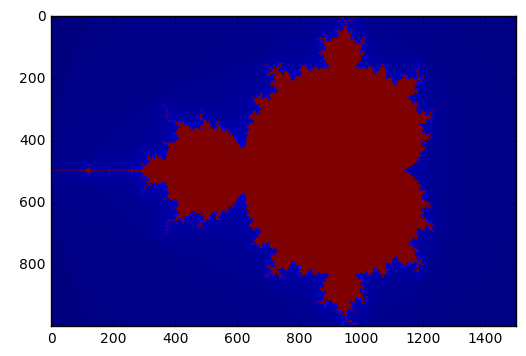

In [8]:

from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import jit
%matplotlib inline

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
imshow(image)
#jet()
#ion()
show()

# Slower!
- PyPy is on the [Raspberry Pi](http://morepypy.blogspot.co.uk/2013/05/pypy-20-alpha-for-arm.html), the $30 linux machine